# Immune Cell Population Analysis
### This notebook analyzes immune cell population data from blood samples, comparing responders and non-responders to treatment.

## 1. Data Loading and Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from IPython.display import display

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

df = pd.read_csv('cell-count.csv')
print("Original data shape:", df.shape)
display(df.head())

Original data shape: (17, 15)


,project,subject,condition,age,sex,treatment,response,sample,sample_type,time_from_treatment_start,b_cell,cd8_t_cell,cd4_t_cell,nk_cell,monocyte
0,prj1,sbj1,melanoma,70,F,tr1,y,s1,PBMC,0.0,36000,24000,42000,6000,12000
1,prj1,sbj1,melanoma,70,F,tr1,y,s2,PBMC,7.0,30000,22000,40000,2000,6000
2,prj1,sbj1,melanoma,70,F,tr1,y,s3,PBMC,14.0,35000,26250,37500,10000,16250
3,prj1,sbj2,healthy,65,F,none,NaN,s4,PBMC,NaN,27900,17100,18000,4500,22500
4,prj1,sbj3,melanoma,75,M,tr1,n,s5,PBMC,0.0,60000,30000,37500,4500,18000


## 2. Convert Cell Counts to Relative Frequencies

In [3]:
populations = ['b_cell', 'cd8_t_cell', 'cd4_t_cell', 'nk_cell', 'monocyte']

df['total_count'] = df[populations].sum(axis=1)

melted = df.melt(id_vars=['sample', 'total_count'], 
                 value_vars=populations,
                 var_name='population',
                 value_name='count')
melted['percentage'] = (melted['count'] / melted['total_count']) * 100

result = melted[['sample', 'total_count', 'population', 'count', 'percentage']]

result.to_csv('cell_count_percentages.csv', index=False)
print("Relative frequencies calculated and saved to cell_count_percentages.csv")

display(result.head())


Relative frequencies calculated and saved to cell_count_percentages.csv


,sample,total_count,population,count,percentage
0,s1,120000,b_cell,36000,30.0
1,s2,100000,b_cell,30000,30.0
2,s3,125000,b_cell,35000,28.0
3,s4,90000,b_cell,27900,31.0
4,s5,150000,b_cell,60000,40.0


## 3. Analysis of Responders vs Non-Responders

### 3.1 Filter Data for TR1 Treatment and PBMC Samples

In [5]:
tr1_pbmc = df[(df['treatment'] == 'tr1') & (df['sample_type'] == 'PBMC')]

analysis_df = pd.merge(tr1_pbmc[['sample', 'project', 'condition', 'response', 'sex']], 
                      result, on='sample')

melanoma_df = analysis_df[analysis_df['condition'] == 'melanoma']

print(f"Found {melanoma_df['sample'].nunique()} melanoma samples from {melanoma_df['project'].nunique()} projects")
display(melanoma_df.head())

Found 9 melanoma samples from 3 projects


,sample,project,condition,response,sex,total_count,population,count,percentage
0,s1,prj1,melanoma,y,F,120000,b_cell,36000,30.0
1,s1,prj1,melanoma,y,F,120000,cd8_t_cell,24000,20.0
2,s1,prj1,melanoma,y,F,120000,cd4_t_cell,42000,35.0
3,s1,prj1,melanoma,y,F,120000,nk_cell,6000,5.0
4,s1,prj1,melanoma,y,F,120000,monocyte,12000,10.0


### 3.2 Boxplot Comparison of Cell Populations

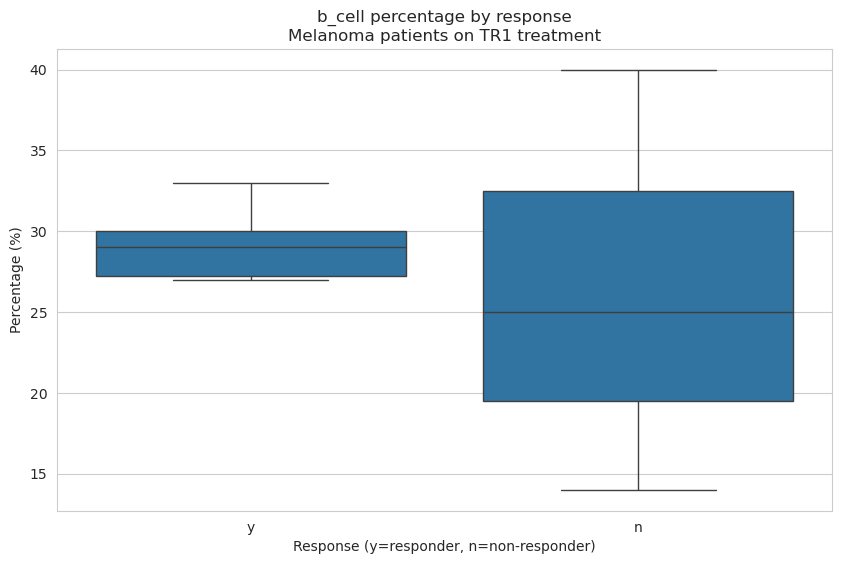

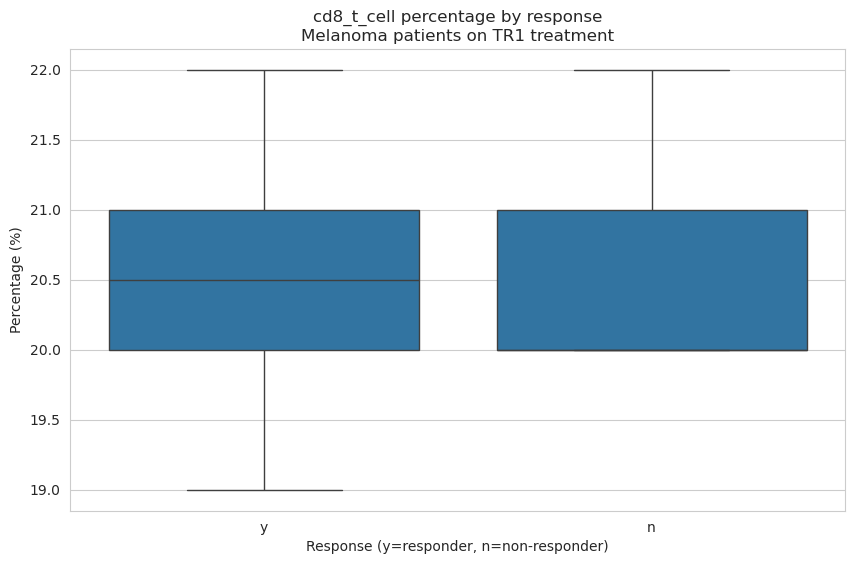

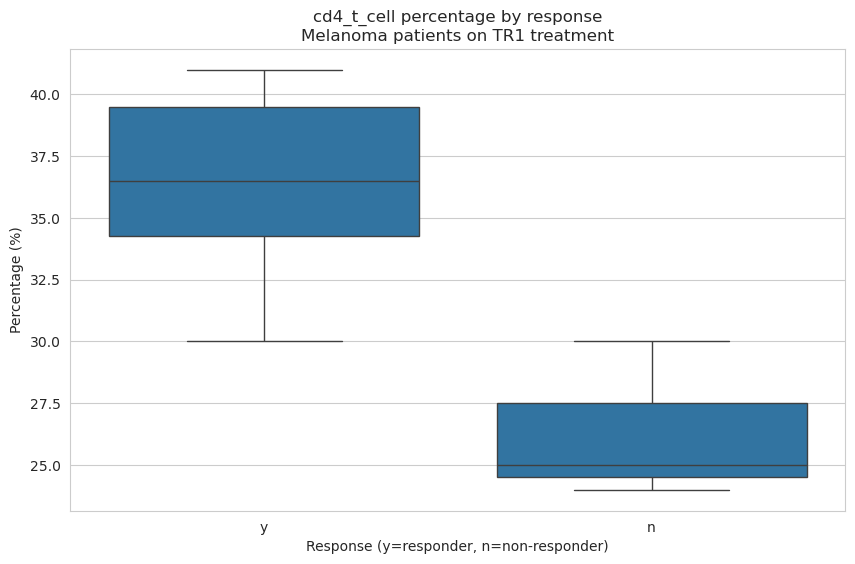

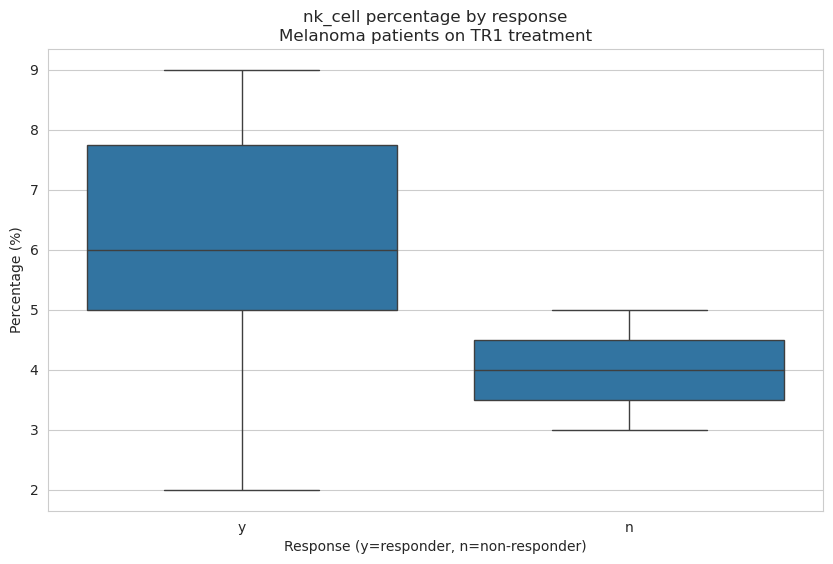

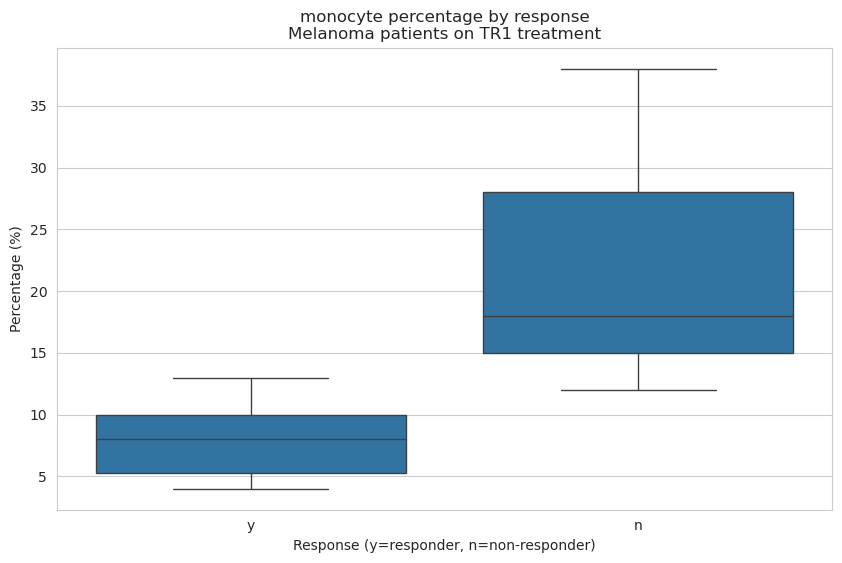

In [6]:
for pop in populations:
    plt.figure()
    sns.boxplot(data=melanoma_df[melanoma_df['population'] == pop], 
                x='response', y='percentage')
    plt.title(f'{pop} percentage by response\nMelanoma patients on TR1 treatment')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Response (y=responder, n=non-responder)')
    plt.savefig(f'{pop}_response_comparison.png', bbox_inches='tight', dpi=300)
    plt.show()

### 3.3 Statistical Comparison

In [8]:
# Mann-Whitney U test for each population
results = []
for pop in populations:
    responders = melanoma_df[(melanoma_df['population'] == pop) & 
                            (melanoma_df['response'] == 'y')]['percentage']
    non_responders = melanoma_df[(melanoma_df['population'] == pop) & 
                               (melanoma_df['response'] == 'n')]['percentage']
    
    stat, p = mannwhitneyu(responders, non_responders)
    results.append({
        'population': pop,
        'responder_median': responders.median(),
        'non_responder_median': non_responders.median(),
        'median_diff': responders.median() - non_responders.median(),
        'statistic': stat,
        'p_value': p
    })

results_df = pd.DataFrame(results)
display(results_df[['population', 'responder_median', 'non_responder_median', 
                   'median_diff', 'p_value']].sort_values('p_value'))


,population,responder_median,non_responder_median,median_diff,p_value
2,cd4_t_cell,36.5,25.0,11.5,0.038056
4,monocyte,8.0,18.0,-10.0,0.051822
3,nk_cell,6.0,4.0,2.0,0.237302
0,b_cell,29.0,25.0,4.0,0.515082
1,cd8_t_cell,20.5,20.0,0.5,1.000000


### 3.4 Summary of Significant Findings

In [9]:
significant_results = results_df[results_df['p_value'] < 0.05]

if not significant_results.empty:
    print("Significantly different cell populations between responders and non-responders:")
    for _, row in significant_results.iterrows():
        print(f"\n- {row['population']}:")
        print(f"  Responders median: {row['responder_median']:.2f}%")
        print(f"  Non-responders median: {row['non_responder_median']:.2f}%")
        print(f"  Difference: {row['median_diff']:.2f}%")
        print(f"  p-value: {row['p_value']:.4f}")
else:
    print("No cell populations showed statistically significant differences at p < 0.05")

Significantly different cell populations between responders and non-responders:

- cd4_t_cell:
  Responders median: 36.50%
  Non-responders median: 25.00%
  Difference: 11.50%
  p-value: 0.0381


## 4. Demographic Breakdown of Melanoma Samples

### 4.1 Samples by Project

In [11]:
project_counts = melanoma_df[['sample', 'project']].drop_duplicates()['project'].value_counts()
print("Samples by project:")
display(project_counts)


Samples by project:


project
prj1    5
prj2    2
prj3    2
Name: count, dtype: int64

### 4.2 Response Status

In [12]:
response_counts = melanoma_df[['sample', 'response']].drop_duplicates()['response'].value_counts()
print("Response status:")
display(response_counts)

Response status:


response
y    6
n    3
Name: count, dtype: int64

### 4.3 Sex Distribution

In [13]:
sex_counts = melanoma_df[['sample', 'sex']].drop_duplicates()['sex'].value_counts()
print("Sex distribution:")
display(sex_counts)


Sex distribution:


sex
F    5
M    4
Name: count, dtype: int64

## 5. Database Schema Proposal

```sql
-- Main Tables
CREATE TABLE Projects (
     project_id VARCHAR(20) PRIMARY KEY,
     project_name VARCHAR(100),
     description TEXT,
     start_date DATE,
     end_date DATE
);
 CREATE TABLE Subjects (
     subject_id VARCHAR(20) PRIMARY KEY,
     project_id VARCHAR(20) REFERENCES Projects(project_id),
     external_subject_id VARCHAR(50),
     age INTEGER,
     sex CHAR(1),
     condition VARCHAR(50),
     other_demographics JSONB
 );

 CREATE TABLE Treatments (
     treatment_id VARCHAR(20) PRIMARY KEY,
     treatment_name VARCHAR(50),
     description TEXT
 );

 CREATE TABLE Subject_Treatment (
     subject_treatment_id SERIAL PRIMARY KEY,
     subject_id VARCHAR(20) REFERENCES Subjects(subject_id),
     treatment_id VARCHAR(20) REFERENCES Treatments(treatment_id),
     start_date DATE,
     response CHAR(1),
     response_date DATE
 );

 CREATE TABLE Samples (
     sample_id VARCHAR(20) PRIMARY KEY,
     subject_id VARCHAR(20) REFERENCES Subjects(subject_id),
     external_sample_id VARCHAR(50),
     sample_type VARCHAR(20),
     collection_date DATE,
     time_from_treatment_start INTEGER,
     processing_notes TEXT
 );

 CREATE TABLE Cell_Populations (
     population_id VARCHAR(20) PRIMARY KEY,
     population_name VARCHAR(50),
     description TEXT
 );

 CREATE TABLE Cell_Counts (
     count_id SERIAL PRIMARY KEY,
     sample_id VARCHAR(20) REFERENCES Samples(sample_id),
     population_id VARCHAR(20) REFERENCES Cell_Populations(population_id),
     cell_count INTEGER,
     percentage FLOAT,
     measurement_date DATE
 );
 ```

## 6. Example Database Queries

### 6.1 Subjects per Condition

```sql
 SELECT condition, COUNT(DISTINCT subject_id) as subject_count
 FROM Subjects
 GROUP BY condition
 ORDER BY subject_count DESC;
 ```

### 6.2 Melanoma PBMC Samples at Baseline with TR1 Treatment

```sql
 SELECT s.sample_id, s.external_sample_id, subj.external_subject_id, 
        subj.condition, st.response
 FROM Samples s
 JOIN Subjects subj ON s.subject_id = subj.subject_id
 JOIN Subject_Treatment st ON subj.subject_id = st.subject_id
 JOIN Treatments t ON st.treatment_id = t.treatment_id
 WHERE subj.condition = 'melanoma'
   AND s.sample_type = 'PBMC'
   AND s.time_from_treatment_start = 0
   AND t.treatment_name = 'tr1';
 ```

## 7. Summary and Conclusions

In [15]:
summary = """
## Key Findings:

1. Cell Population Differences:
   - {significant_findings}

2. Sample Characteristics:
   - Total melanoma samples analyzed: {n_samples}
   - Projects represented: {n_projects}
   - Responders: {n_responders} | Non-responders: {n_non_responders}
   - Male/Female distribution: {male_female}
""".format(
    significant_findings="\n   - ".join([
        f"{row['population']} (p={row['p_value']:.3f}, Δ={row['median_diff']:.1f}%)" 
        for _, row in significant_results.iterrows()
    ]) if not significant_results.empty else "No significant differences found",
    n_samples=melanoma_df['sample'].nunique(),
    n_projects=melanoma_df['project'].nunique(),
    n_responders=response_counts.get('y', 0),
    n_non_responders=response_counts.get('n', 0),
    male_female=f"M: {sex_counts.get('M', 0)}, F: {sex_counts.get('F', 0)}",
    top_population=significant_results.iloc[0]['population'] if not significant_results.empty else "all populations"
)

print(summary)


## Key Findings:

1. Cell Population Differences:
   - cd4_t_cell (p=0.038, Δ=11.5%)

2. Sample Characteristics:
   - Total melanoma samples analyzed: 9
   - Projects represented: 3
   - Responders: 6 | Non-responders: 3
   - Male/Female distribution: M: 4, F: 5

